1. Find field data;
2. Load corresponding surface reflectance from datacube or pickle;
3. Calculate FC and compare to field data.

In [1]:
# define sensor_name
#sensor_name = 'Landsat 8 noscaling'
#sensor_name = 'Landsat 8 current'
sensor_name = 'Landsat 8'
#sensor_name = 'Landsat 7'
#sensor_name = 'Sentinel 2A'
#sensor_name = 'Sentinel 2B'

In [2]:
%matplotlib inline
import warnings; warnings.simplefilter('ignore')
import datacube
from datacube.storage import masking
from fc.fractional_cover import compute_fractions

import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
from matplotlib import pyplot as plt
from matplotlib import gridspec 
from shapely import wkt

In [28]:
# Function to compute the fractional covers as viewed by the satellite for the site
# Required a site properties object
def fractionalCoverSatView(siteProperties):
    nTotal = siteProperties['num_points']
    # Canopy Layer
    nCanopyBranch = siteProperties['over_b'] * nTotal / 100.0
    nCanopyDead = siteProperties['over_d'] * nTotal / 100.0
    nCanopyGreen = siteProperties['over_g'] * nTotal / 100.0
    # Midstory Layer
    nMidBranch = siteProperties['mid_b'] * nTotal / 100.0
    nMidGreen = siteProperties['mid_g'] * nTotal / 100.0
    nMidDead = siteProperties['mid_d'] * nTotal / 100.0
    # Ground Layer
    nGroundDeadLitter = (siteProperties['dead'] + siteProperties['litter']) * nTotal / 100.0
    nGroundCrustDistRock = (siteProperties['crust'] + siteProperties['dist'] + siteProperties['rock']) * nTotal / 100.0
    nGroundGreen = siteProperties['green'] * nTotal / 100.0
    nGroundCrypto = siteProperties['crypto'] * nTotal / 100.0
    # Work out the canopy elements as viewed from above
    canopyFoliageProjectiveCover = nCanopyGreen / (nTotal - nCanopyBranch)
    canopyDeadProjectiveCover = nCanopyDead / (nTotal - nCanopyBranch)
    canopyBranchProjectiveCover = nCanopyBranch / nTotal * (1.0 - canopyFoliageProjectiveCover - canopyDeadProjectiveCover)
    canopyPlantProjectiveCover = (nCanopyGreen+nCanopyDead + nCanopyBranch) / nTotal
    # Work out the midstorey fractions
    midFoliageProjectiveCover = nMidGreen / nTotal
    midDeadProjectiveCover = nMidDead / nTotal
    midBranchProjectiveCover = nMidBranch / nTotal
    midPlantProjectiveCover = (nMidGreen + nMidDead + nMidBranch) / nTotal
    # Work out the midstorey  elements as viewed by the satellite using a gap fraction method
    satMidFoliageProjectiveCover = midFoliageProjectiveCover * (1 - canopyPlantProjectiveCover)
    satMidDeadProjectiveCover = midDeadProjectiveCover * (1 - canopyPlantProjectiveCover)
    satMidBranchProjectiveCover = midBranchProjectiveCover * (1 - canopyPlantProjectiveCover)
    satMidPlantProjectiveCover = midPlantProjectiveCover * (1 - canopyPlantProjectiveCover)
    # Work out the groundcover fractions as seen by the observer
    groundPVCover = nGroundGreen / nTotal
    groundNPVCover = nGroundDeadLitter / nTotal
    groundBareCover = nGroundCrustDistRock / nTotal
    groundCryptoCover = nGroundCrypto / nTotal
    groundTotalCover = (nGroundGreen + nGroundDeadLitter + nGroundCrustDistRock) / nTotal
    # Work out the ground cover propoetions as seen by the satellite
    satGroundPVCover = groundPVCover * (1 - midPlantProjectiveCover) * (1 - canopyPlantProjectiveCover)
    satGroundNPVCover = groundNPVCover * ( 1- midPlantProjectiveCover) * (1 - canopyPlantProjectiveCover)
    satGroundBareCover = groundBareCover * (1 - midPlantProjectiveCover) * (1 - canopyPlantProjectiveCover)
    satGroundCryptoCover = groundCryptoCover * (1 - midPlantProjectiveCover) * (1 - canopyPlantProjectiveCover)
    satGroundTotalCover = groundTotalCover * (1 - midPlantProjectiveCover) * (1 - canopyPlantProjectiveCover)
    # Final total covers calculated using gap probabilities through all layers
    totalPVCover = canopyFoliageProjectiveCover + satMidFoliageProjectiveCover + satGroundPVCover
    totalNPVCover = canopyDeadProjectiveCover + canopyBranchProjectiveCover + satMidDeadProjectiveCover + satMidBranchProjectiveCover + satGroundNPVCover
    totalBareCover = satGroundBareCover
    totalCryptoCover = satGroundCryptoCover
    
    return np.array([totalPVCover,totalNPVCover+totalCryptoCover,totalBareCover])

In [4]:
# coefficients for FC compute
ls8_coefficients_current = {'blue': [0.00041, 0.9747], 'green': [0.00289, 0.99779], 'red': [0.00274, 1.00446], 
                       'nir': [4e-05, 0.98906], 'swir1': [0.00256, 0.99467], 'swir2': [-0.00327, 1.02551]}

ls8_coefficients = {'blue': [0.00041*1e4, 0.9747], 'green': [0.00289*1e4, 0.99779], 'red': [0.00274*1e4, 1.00446], 
                       'nir': [4e-05*1e4, 0.98906], 'swir1': [0.00256*1e4, 0.99467], 'swir2': [-0.00327*1e4, 1.02551]}

s2_coefficients = {'blue':[-0.0022*1e4, 0.9551],
                   'green':[0.0031*1e4, 1.0582],
                   'red':[0.0064*1e4, 0.9871],
                   'nir':[0.012*1e4, 1.0187],
                   'swir1':[0.0079*1e4, 0.9528],
                   'swir2':[-0.0042*1e4, 0.9688]}

# compute FC 
def compute_fc(input_ds, regression_coefficients):
    input_data = input_ds.to_array().data
    is_valid_array= (input_data >0).all(axis=0)
    # Set nodata to 0                                                       
    input_data[:, ~is_valid_array] = 0
    # compute fractional_cover
    output_data = compute_fractions(input_data, regression_coefficients)
    output_data[:, ~is_valid_array] = -1
    return xr.DataArray(output_data, dims=('band','y','x'),
                        coords={'x':input_ds.x, 'y':input_ds.y, 'band':['PV', 'NPV', 'BS', 'UE']})

In [5]:
# select good pixels using pixel quality
def ls_good(pq):
    return masking.make_mask(pq, cloud_acca = "no_cloud", cloud_fmask = "no_cloud",
                             cloud_shadow_acca = "no_cloud_shadow",
                             cloud_shadow_fmask = "no_cloud_shadow",
                             contiguous = True)
def s2_good(pq):
    return pq == 1

In [6]:
# spectral bands used for fractional cover calculation
ls_bands = ['green','red','nir','swir1','swir2']
s2_bands = ['nbart_green','nbart_red','nbart_nir_1','nbart_swir_2','nbart_swir_3']

# sensor specific configurations
sensor_config = {'Landsat 7':{'startdate':'1999-05-01', 'product':'ls7_nbart_albers', 'bands':ls_bands,
                              'resolution':(25,25), 'fc_coefficients': None,
                             'pq_product':'ls7_pq_albers', 'pq_band':'pixelquality', 'pq_mask': ls_good}, 
                 'Landsat 8 noscaling':{'startdate':'2013-03-01', 'product':'ls8_nbart_albers', 'bands':ls_bands,
                              'resolution':(25,25), 'fc_coefficients': None,
                             'pq_product':'ls8_pq_albers', 'pq_band':'pixelquality', 'pq_mask': ls_good}, 
                 'Landsat 8':{'startdate':'2013-03-01', 'product':'ls8_nbart_albers', 'bands':ls_bands,
                              'resolution':(25,25), 'fc_coefficients':ls8_coefficients,
                             'pq_product':'ls8_pq_albers', 'pq_band':'pixelquality', 'pq_mask': ls_good}, 
                 'Landsat 8 current':{'startdate':'2013-03-01', 'product':'ls8_nbart_albers', 'bands':ls_bands,
                              'resolution':(25,25), 'fc_coefficients':ls8_coefficients_current,
                             'pq_product':'ls8_pq_albers', 'pq_band':'pixelquality', 'pq_mask': ls_good}, 
                 'Sentinel 2A':{'startdate':'2015-07-01', 'product':'s2a_ard_granule', 'bands':s2_bands,
                              'resolution':(10,10), 'fc_coefficients':s2_coefficients,
                             'pq_product':'s2a_ard_granule', 'pq_band':'fmask', 'pq_mask': s2_good},
                'Sentinel 2B':{'startdate':'2017-06-01', 'product':'s2b_ard_granule', 'bands':s2_bands,
                              'resolution':(10,10), 'fc_coefficients':s2_coefficients,
                             'pq_product':'s2b_ard_granule', 'pq_band':'fmask', 'pq_mask': s2_good}
                }

In [7]:
# Load star_transects field data
field = pd.read_csv('star_transects.csv')
field['geometry'] = field.geom.apply(wkt.loads)
field = gpd.GeoDataFrame(field)
field.crs = {'init': 'EPSG:4326'}
field = field.to_crs({'init':'EPSG:3577'})

In [8]:
# Filter data by date
field = field.loc[field['obs_time'] > sensor_config[sensor_name]['startdate']]

In [9]:
# Calculate field measured fractions
field = field.merge(
    field.apply(fractionalCoverSatView, axis=1, result_type= 'expand').rename(
        columns = {0:'total_pv',1:'total_npv',2:'total_bs'}),
    left_index=True, right_index=True)
field = field[field.apply(lambda x: x['total_pv']+x['total_npv']+x['total_bs'], axis=1) >0.95]

In [10]:
# Match to albers tiles to check distribution
albers_tiles = gpd.read_file('/g/data/u46/users/fxy120/sensor_data_maps/Albers_Australia_Coast_and_Islands.shp')
albers_tiles.crs = {'init':'EPSG:3577'}
matched = gpd.sjoin(field, albers_tiles, how='inner', op = 'intersects')
field_tiles = albers_tiles.merge(matched.groupby('label')['FID'].count().sort_values(ascending=False).to_frame('count').reset_index()
    , on='label', how='right')
print("Total number of data points is",len(field))
print("Largest number of data points in a tile is", field_tiles.loc[field_tiles['count'].idxmax()]['count'])

Total number of data points is 2236
Largest number of data points in a tile is 70


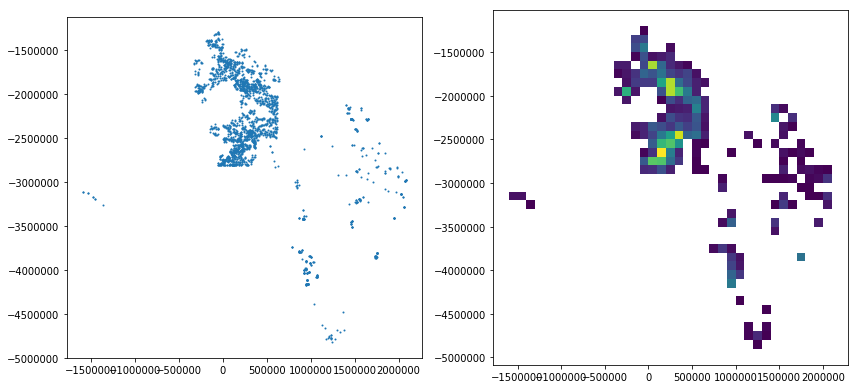

In [11]:
# Visual check of field data distribution
f, axes = plt.subplots(1, 2, figsize=(14,7))
field.plot(markersize=1, ax=axes[0])
field_tiles.plot(column='count', cmap = 'viridis', ax=axes[1])

In [12]:
# load data from cube
dc = datacube.Datacube()

In [13]:
# find temporally and spatially aligned EO data 
# calculate fractional cover
def fractionalCover(row, sensor_config = sensor_config[sensor_name], plot_rad = 50, window_days = 15):
    # nodata default
    fc_dict = {'fc_time': '', 'pv': -1, 'npv': -1, 'bs': -1, 'pv_std': -1, 'npv_std': -1, 'bs_std': -1 }
    # define search
    x = row.geometry.x - plot_rad, row.geometry.x + plot_rad
    y = row.geometry.y - plot_rad, row.geometry.y + plot_rad
    time = (str(np.datetime64(row.obs_time) - np.timedelta64(window_days,'D')),
            str(np.datetime64(row.obs_time) + np.timedelta64(window_days,'D'))
           )
    # search for nbart and require result
    nbart = dc.load(product = sensor_config['product'], 
        measurements = sensor_config['bands'],
        group_by = 'solar_day',
        x = x, y = y, crs = 'EPSG:3577', time = time, resolution = sensor_config['resolution'], output_crs = 'EPSG:3577'
       )
    if not nbart: return fc_dict
    # search for pixel quality and require result
    pq = dc.load(product = sensor_config['pq_product'], 
        measurements = [sensor_config['pq_band']],
        group_by = 'solar_day',
        x = x, y = y, crs = 'EPSG:3577', time = time, resolution = sensor_config['resolution'], output_crs = 'EPSG:3577'
       )
    if not pq: return fc_dict
    # filter by pixel quality and require good pixels
    good = pq.apply(sensor_config['pq_mask'])[sensor_config['pq_band']]
    nbart = nbart.where(good, drop=True).sel(x = slice(x[0],x[1]), y = slice(y[0],y[1]))
    if len(nbart.time) == 0: return fc_dict
    # require all pixels to be clear
    nbart.isel(time = ~nbart.isnull().to_array(dim='band').groupby('time','band').any().values)
    if len(nbart.time) == 0: return fc_dict
    # only keep closest time
    nbart = nbart.isel(time=[np.abs(nbart.time-np.datetime64(row.obs_time)).argmin()])
    # compute FC
    fc = nbart.groupby('time').apply(compute_fc,
                                     regression_coefficients = sensor_config['fc_coefficients'],
                                    ).to_dataset(dim='band')
    # take average
    fc_mean = fc.where(fc>=0).groupby('time').mean()
    fc_std = fc.where(fc>=0).groupby('time').std()
    
    fc_dict['fc_time'] = fc.time.values[0].astype(str)
    for var_name in fc_mean.data_vars:
        fc_dict[var_name.lower()] = fc_mean[var_name].values[0]
        fc_dict[var_name.lower()+'_std'] = fc_std[var_name].values[0]
    return fc_dict

In [14]:
# find temporally and spatially aligned FC data
def get_fractionalCover(row, sensor_config = sensor_config[sensor_name], plot_rad = 50, window_days =15 ):
    # nodata default
    fc_dict = {'fc_time': '', 'pv': -1, 'npv': -1, 'bs': -1, 'pv_std': -1, 'npv_std': -1, 'bs_std': -1 }
    # define search
    x = row.geometry.x - plot_rad, row.geometry.x + plot_rad
    y = row.geometry.y - plot_rad, row.geometry.y + plot_rad
    time = (str(np.datetime64(row.obs_time) - np.timedelta64(window_days,'D')),
            str(np.datetime64(row.obs_time) + np.timedelta64(window_days,'D'))
           )
    # search for nbart and require result
    fc = dc.load(product = sensor_config['product'].replace('nbart','fc'), 
        #measurements = sensor_config['bands'],
        group_by = 'solar_day',
        x = x, y = y, crs = 'EPSG:3577', time = time, resolution = sensor_config['resolution'], output_crs = 'EPSG:3577'
       )
    if not fc: return fc_dict
    # search for pixel quality and require result
    pq = dc.load(product = sensor_config['pq_product'], 
        measurements = [sensor_config['pq_band']],
        group_by = 'solar_day',
        x = x, y = y, crs = 'EPSG:3577', time = time, resolution = sensor_config['resolution'], output_crs = 'EPSG:3577'
       )
    if not pq: return fc_dict
    # filter by pixel quality and require good pixels
    good = pq.apply(sensor_config['pq_mask'])[sensor_config['pq_band']]
    fc = fc.where(good, drop=True).sel(x = slice(x[0],x[1]), y = slice(y[0],y[1]))
    if len(fc.time) == 0: return fc_dict
    # require all pixels to be clear
    fc.isel(time = ~fc.isnull().to_array(dim='band').groupby('time','band').any().values)
    if len(fc.time) == 0: return fc_dict
    # only keep closest time
    fc = fc.isel(time=[np.abs(fc.time-np.datetime64(row.obs_time)).argmin()])
    # take average
    fc_mean = fc.where(fc>=0).groupby('time').mean()
    fc_std = fc.where(fc>=0).groupby('time').std()
    
    fc_dict['fc_time'] = fc.time.values[0].astype(str)
    for var_name in fc_mean.data_vars:
        fc_dict[var_name.lower()] = fc_mean[var_name].values[0]
        fc_dict[var_name.lower()+'_std'] = fc_std[var_name].values[0]
    return fc_dict

In [15]:
%%time
fractions = field.apply(fractionalCover, axis=1, result_type = 'expand')
field = field.merge(fractions, how = 'inner', left_index=True, right_index=True)
field = field[field['pv']>=0]

CPU times: user 15min 10s, sys: 4min 57s, total: 20min 7s
Wall time: 40min 44s


In [16]:
field.to_file('field_with_fc_%s.shp'%''.join(sensor_name.split()))

In [17]:
field = gpd.read_file('field_with_fc_%s.shp'%''.join(sensor_name.split()))

# of validation points: 2081
Band:BS, slope=1.0040103718119264, r2=0.5700872085130045
Correlations: 0.8398833947267859 0.853024132834849 0.6589325974414257
RMSE: 14.134321789702922
Band:PV, slope=0.894343256391839, r2=0.6345437850650815
Correlations: 0.8445800936888688 0.7714651624824125 0.5834739373896579
RMSE: 8.601253641812564
Band:NPV, slope=0.8323908982786251, r2=0.46479700262422435
Correlations: 0.7618682064370056 0.7750268223574615 0.5839934268658441
RMSE: 16.880976731958224


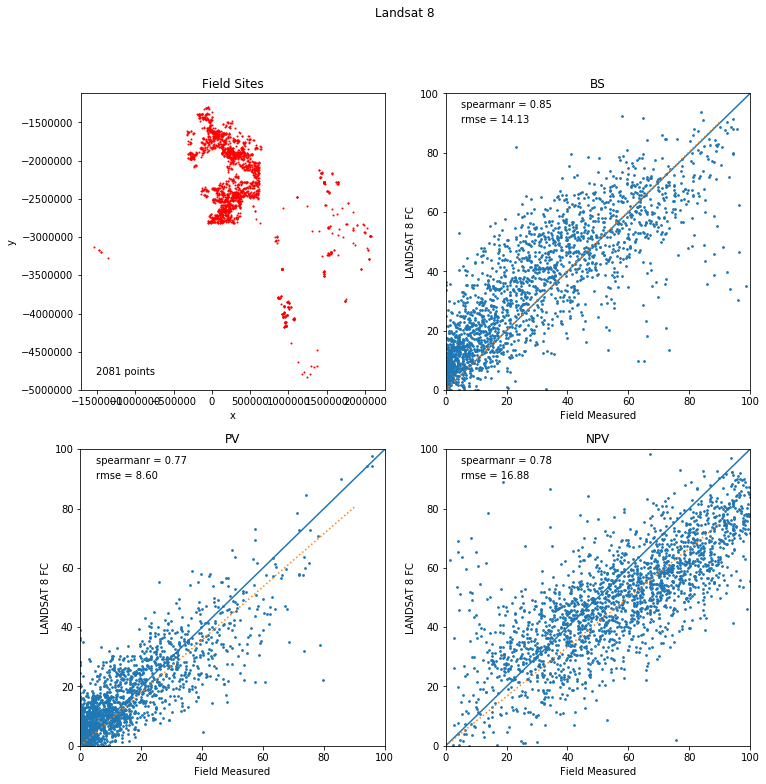

In [37]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr, spearmanr, kendalltau

regr = linear_model.LinearRegression(fit_intercept=False)    

f = plt.figure(figsize=(12,12))
gs = gridspec.GridSpec(2,2)

xedges=yedges=list(np.arange(0,102,2))
X, Y = np.meshgrid(xedges, yedges)
cmname='YlGnBu'
   
ax1 = plt.subplot(gs[0])
#     field.plot(markersize=1, ax= ax1, color='r')
#     ax1.set_xlabel('x')
#     ax1.set_ylabel('y')
#    # ax1.set_title('Field Sites')
#     ax1.text(0.05, 0.05, "%d points"%len(field), transform=ax1.transAxes)
    
    rmses = []
    for band_id, band in enumerate(['BS','PV','NPV']):
        arr1 = field['total_%s'%band.lower()].values.ravel()*100.
        arr2 = field[band.lower()].values.ravel()
        regr.fit(arr1[:,np.newaxis], arr2[:,np.newaxis])
        
        print('Band:{0}, slope={1}, r2={2}'.format(band, regr.coef_[0][0],
                                                regr.score(arr1[:,np.newaxis], arr2[:,np.newaxis])))
        sr = spearmanr(arr1, arr2)[0]
        print('Correlations:', pearsonr(arr1, arr2)[0], sr, kendalltau(arr1, arr2)[0])
        rmse = np.sqrt(mean_squared_error(arr1, arr2))
        print('RMSE:',rmse)
        rmses.append(rmse)

        ax1 = plt.subplot(gs[band_id+1])
        ax1.scatter(arr1, arr2, s=3)
        ax1.set_title(band)
        
        ax1.plot([0,100],[0,100])
        ax1.plot(np.arange(0,100,10), regr.predict(np.arange(0,100,10)[:,np.newaxis]), ':')
        ax1.text(5, 95, 'spearmanr = {0:.2f}'.format(sr))
        ax1.text(5, 90, 'rmse = {0:.2f}'.format(rmse))
        ax1.set_xlabel('Field Measured')
        ax1.set_ylabel('%s FC'%sensor_name.upper())
        ax1.set_xlim((0,100))
        ax1.set_ylim((0,100))
    
    f.savefig('validate_fc_%s.png'%''.join(sensor_name.split()))


validate(field, title=sensor_name)
